In [4]:
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
### HAMILTONIAN start
Molecule = 'H2'
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian_PySCF(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='JW')
### HAMILTONIAN end

#####################################

Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)
anti_commuting_sets

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 699.15it/s]


{0: [(0.12062523483390414+0j) [Z0 Z2]],
 1: [(0.1744128761226159+0j) [Z2 Z3]],
 2: [(0.16868898170361207+0j) [Z0 Z1]],
 3: [(0.1659278503377034+0j) [Z1 Z2]],
 4: [(0.1659278503377034+0j) [Z0 Z3]],
 5: [(-0.09706626816762878+0j) []],
 6: [(0.12062523483390414+0j) [Z1 Z3]],
 7: [(0.1714128264477689+0j) [Z0], (0.045302615503799264+0j) [Y0 X1 X2 Y3]],
 8: [(-0.22343153690813564+0j) [Z2], (-0.045302615503799264+0j) [Y0 Y1 X2 X3]],
 9: [(0.17141282644776892+0j) [Z1], (0.045302615503799264+0j) [X0 Y1 Y2 X3]],
 10: [(-0.22343153690813558+0j) [Z3],
  (-0.045302615503799264+0j) [X0 X1 Y2 Y3]]}

In [5]:
from quchem.LCU_method import *

$$U_{UCCSD}^{H2}=e^{-i \theta Y_{0} X_{1} X_{2} X_{3}}$$

In [6]:
from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator

def H2_ansatz(theta):
    HF_circ = [cirq.X.on(cirq.LineQubit(0)), cirq.X.on(cirq.LineQubit(1))]
    
    full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator('Y0 X1 X2 X3', -1j), theta)
    UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
    full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations()])
    
    return full_circuit


## Wavefunction Method

In [7]:
THETA = np.pi

ansatz_cirq_circuit = H2_ansatz(THETA)

testing =  VQE_Experiment_LCU_UP_lin_alg(anti_commuting_sets,
                 ansatz_cirq_circuit,
                 Hamilt.molecule.n_qubits,
                 N_indices_dict={7:1, 8:1, 9:0, 10:0})
testing.Calc_Energy()

(-1.1167593041803572+0j)

In [8]:
def GIVE_ENERGY_lin_alg(THETA):
   
    ansatz_cirq_circuit = H2_ansatz(THETA)

    VQE_exp_LCU_lin_alg = VQE_Experiment_LCU_UP_lin_alg(anti_commuting_sets,
                 ansatz_cirq_circuit,
                 Hamilt.molecule.n_qubits,
                 N_indices_dict={7:0, 8:0, 9:1, 10:1})
    
    return VQE_exp_LCU_lin_alg.Calc_Energy()

GIVE_ENERGY_lin_alg(np.pi)

(-1.1167593041803572+0j)

(-1.137019067777205+3.7930560639270463e-10j)


/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


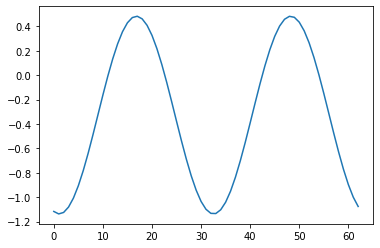

In [9]:
### full angle scan
import matplotlib.pyplot as plt
%matplotlib inline

theta_list = np.arange(0,2*np.pi, 0.1)
# theta_list = np.arange(0.98*np.pi, 1.02*np.pi, 0.001)

E_list = [GIVE_ENERGY_lin_alg(theta) for theta in theta_list]

plt.plot(E_list)
print(min(E_list))

# longer Ansatz

In [12]:
from quchem.Ansatz_Generator_Functions import *
input_state = ansatz_obj.Get_JW_HF_state_in_OCC_basis()
print(input_state)

UCCSD_ansatz_Q_Circ_obj = Ansatz_Circuit(input_state,
                                     Qubit_Op_list_Second_Quant_CC_Ops_ia, 
                                     Qubit_Op_list_Second_Quant_CC_Ops_ijab)

ansatz_cirq_circuit =UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(Theta_param_list_ia=theta_parameters_ia, 
                                         Theta_param_list_ijab=theta_parameters_ijab,
                                         ia_first=True)
ansatz_cirq_circuit

[1, 1, 0, 0]


0: ───X───Rx(0.5π)───@───────────────────────@───Rx(-0.5π)───H───@──────────────────────@───────────H──────────H─────────────────────────────────────────────────────────────────────────────────────────────@───────────────────────────────@───────────H──────────Rx(0.5π)───@──────────────────────────────@───────────Rx(-0.5π)───Rx(0.5π)───@──────────────────────────────@───Rx(-0.5π)───H──────────@──────────────────────────────@──────────H───────────Rx(0.5π)───@───────────────────────────────────────@───────────Rx(-0.5π)───H──────────@───────────────────────────────────────@───────────H───────────H───@───────────────────────────────────────@──────────H───Rx(0.5π)───@──────────────────────────────────────@───Rx(-0.5π)───
                     │                       │                   │                      │                                                                                                                    │                               │                                 │                              │                                  │                              │                          │                              │                                 │                                       │                                  │                                       │                           │                                       │                         │                                      │
1: ───X──────────────X───@───────────────@───X───────────────────X───@──────────────@───X───────────Rx(0.5π)───@───────────────────────@───Rx(-0.5π)───H───@──────────────────────@───────────H──────────H───X───@───────────────────────@───X───────────H──────────Rx(0.5π)───X───@──────────────────────@───X───────────Rx(-0.5π)───H──────────X───@──────────────────────@───X───H───────────Rx(0.5π)───X───@──────────────────────@───X──────────Rx(-0.5π)───H──────────X───@───────────────────────@───────────X───────────H───────────Rx(0.5π)───X───@───────────────────────@───────────X───────────Rx(-0.5π)───H───X───@───────────────────────@───────────X──────────H───Rx(0.5π)───X───@──────────────────────@───────────X───Rx(-0.5π)───
                         │               │                           │              │                          │                       │                   │                      │                              │                       │                                         │                      │                                          │                      │                                  │                      │                                         │                       │                                                  │                       │                                           │                       │                                         │                      │
2: ───I───H──────────────X───Rz(-0.0π)───X───H───Rx(0.5π)────────────X───Rz(0.0π)───X───Rx(-0.5π)──────────────X───@───────────────@───X───────────────────X───@──────────────@───X───────────Rx(0.5π)───────────X───@───────────────@───X───Rx(-0.5π)───Rx(0.5π)──────────────────X───@──────────────@───X───Rx(-0.5π)───H──────────────────────────X───@──────────────@───X───H───H──────────────────────────X───@──────────────@───X───H──────────Rx(0.5π)───────────────────X───@───────────────@───X───────────Rx(-0.5π)───Rx(0.5π)───────────────────X───@───────────────@───X───────────Rx(-0.5π)───H───────────────────X───@───────────────@───X───────────H──────────H──────────────────X───@──────────────@───X───────────H───────────────
                                                                                                                   │               │                           │              │                                      │               │                                                 │              │                                                  │              │                                          │             

In [15]:
def GIVE_ENERGY_lin_alg_LONG(theta_ia_ijab):
    
    theta_ia= theta_ia_ijab[:(len(theta_parameters_ia))]
    theta_ijab=theta_ia_ijab[(len(theta_parameters_ia)):]
   
    ansatz_cirq_circuit =UCCSD_ansatz_Q_Circ_obj.Get_Full_HF_UCCSD_QC(
                                         Theta_param_list_ia=theta_ia, 
                                         Theta_param_list_ijab=theta_ijab,
                                         ia_first=True)

    VQE_exp_LCU_lin_alg = VQE_Experiment_LCU_UP_lin_alg(anti_commuting_sets,
                 ansatz_cirq_circuit,
                 Hamilt.molecule.n_qubits,
                 N_indices_dict={7:0, 8:1, 9:0, 10:0})
    
    return VQE_exp_LCU_lin_alg.Calc_Energy()


In [16]:
import random

theta_ia_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(theta_parameters_ia))]
theta_ijab_random_input = [random.uniform(0, 2*np.pi) for _ in range(len(theta_parameters_ijab))]

theta_combined_random_input = [*theta_ia_random_input, *theta_ijab_random_input]

GIVE_ENERGY_lin_alg_LONG(theta_combined_random_input)

(0.27477394524418075+5.849542550333723e-08j)

In [17]:
def calc_gradient_ADAM(theta_ia_theta_jab_list):
    
    grad_list=[]
    
    for index, theta in enumerate(theta_ia_theta_jab_list):
        
        new_theta_list = theta_ia_theta_jab_list.copy()
        new_theta_list[index] = theta + np.pi/4
        
        Obs_PLUS = GIVE_ENERGY_lin_alg_LONG(new_theta_list)
               
        
        new_theta_list[index] = theta - np.pi/4
        Obs_MINUS = GIVE_ENERGY_lin_alg_LONG(new_theta_list)
        
        gradient = Obs_PLUS - Obs_MINUS
        
        grad_list.append(gradient)
        

    return np.array(grad_list)

In [18]:
### optimizer
from quchem.Scipy_Optimizer import _minimize_Adam, Optimizer

0: Input_to_Funct: [5.80227679-7.42495570e-16j 2.61438639+2.27701083e-15j
 2.14080516+4.56234177e-16j]: Output: (0.22187015009732192-9.642549843946572e-09j)
1: Input_to_Funct: [5.7270062 +9.27635006e-08j 2.51661966-9.51158893e-09j
 2.23962175-4.13081584e-09j]: Output: (0.18541174965288573+2.8691775898515634e-08j)
2: Input_to_Funct: [5.73874729+2.43937276e-07j 2.42041075-1.51848711e-08j
 2.33577508-4.86209056e-09j]: Output: (0.1485179926607974-9.935155995779556e-08j)
3: Input_to_Funct: [5.79732723+2.77676171e-07j 2.32342603-1.99959854e-08j
 2.43179239+3.59489270e-09j]: Output: (0.08385395823882968-1.742565454895185e-07j)
4: Input_to_Funct: [5.86845034+2.95855118e-07j 2.22541384-2.47502360e-08j
 2.52917442+1.26531486e-08j]: Output: (-0.009455047412160578-2.12676918918179e-07j)
5: Input_to_Funct: [5.94745402+3.11550857e-07j 2.12750102-2.73516788e-08j
 2.62787946+1.99050964e-08j]: Output: (-0.12003618818506556-3.1456519802905767e-07j)
6: Input_to_Funct: [6.03258088+3.23946042e-07j 2.034617

52: Input_to_Funct: [6.37945393-2.16714712e-08j 3.11349625+1.18911618e-07j
 3.29145656+2.74460304e-08j]: Output: (-1.1278304276042024+7.748865938208684e-09j)
53: Input_to_Funct: [6.36997013-2.74911030e-08j 3.11850658+1.01608866e-07j
 3.29774808-2.39123700e-09j]: Output: (-1.1283665408906687-5.8620209278654036e-09j)
54: Input_to_Funct: [6.35728255-2.96041407e-08j 3.12358781+8.13291377e-08j
 3.29929898-2.49035943e-08j]: Output: (-1.1297508028747465-1.6344520084626245e-08j)
55: Input_to_Funct: [6.34223877-2.88302603e-08j 3.12858581+5.72207985e-08j
 3.29643022-3.87676281e-08j]: Output: (-1.1317263431940523-9.15036627279014e-09j)
56: Input_to_Funct: [6.32573838-2.43870081e-08j 3.13334824+3.18578025e-08j
 3.28983314-4.70843647e-08j]: Output: (-1.1338589288159295-1.435094614737583e-08j)
57: Input_to_Funct: [6.30868553-1.74315897e-08j 3.13774954+5.96894868e-09j
 3.28047543-5.09442442e-08j]: Output: (-1.1356844516505287-5.8235283086732434e-09j)
58: Input_to_Funct: [6.29194436-1.12943677e-08j 3.

/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


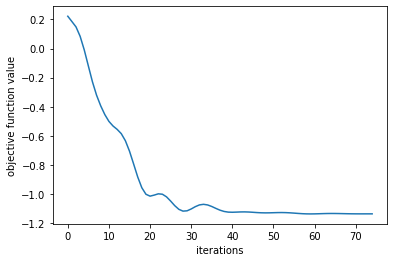

In [20]:
custom_optimizer_DICT = {'learning_rate': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
                           'delta': 1e-8, 'maxfev': 15000}

GG = Optimizer(GIVE_ENERGY_lin_alg_LONG,
                   theta_combined_random_input,
                   args=(),
                   method=_minimize_Adam,
                   jac=calc_gradient_ADAM,
                   hess=None,
                   hessp=None,
                      bounds=None,
                   constraints=None,
                   tol=1e-20, 
                   display_convergence_message=True,
                   display_steps=True, 
                   custom_optimizer_DICT=custom_optimizer_DICT)
GG.get_env(75)
GG.plot_convergence()
plt.show()

# Checking with circuit model

In [ ]:
N_index = 1

R_uncorrected, Pn, gamma_l = Get_R_linear_combination(anti_commuting_sets[9], N_index)
R_corrected_Op_list, R_corr_list, ancilla_amplitudes, l1 = absorb_complex_phases(R_uncorrected)


Q_circuit_no_M_gates = Full_Q_Circuit_NO_M_gates_and_no_Pn(Pn, R_corrected_Op_list, R_corr_list, ancilla_amplitudes, Hamilt.molecule.n_qubits, ansatz_cirq_circuit)
Q_circuit_no_M_gates


# # unitary check
# np.allclose(np.eye(2**5), np.matmul(Q_circuit_no_M_gates._unitary_(), Q_circuit_no_M_gates._unitary_().conj().transpose()))

In [ ]:
simulator = cirq.Simulator()
output_ket = simulator.compute_amplitudes(Q_circuit_no_M_gates,
                                      bitstrings=[i for i in range(2 ** len(Q_circuit_no_M_gates.all_qubits()))])


output_ket = output_ket.reshape([output_ket.shape[0],1])
output_ket

In [ ]:
full_density_matrix = np.outer(output_ket, output_ket)

## Want to project using all 0 ancilla measurement!
n_qubits = 5
n_ancilla = 1
n_system = n_qubits - n_ancilla

I_system_operator = np.eye(2**(n_system))

zero_state = np.array([[1],[0]])
ancilla_0_state_list = [zero_state for _ in range(n_ancilla)]
ancilla_0_state = reduce(np.kron, ancilla_0_state_list)

ancilla_0_projector = np.outer(ancilla_0_state,ancilla_0_state)
POVM_0_ancilla = np.kron(I_system_operator, ancilla_0_projector)
Kraus_Op_0 = POVM_0_ancilla.copy()

In [ ]:
term = Kraus_Op_0.dot(full_density_matrix.dot(Kraus_Op_0.transpose().conj()))
term

In [ ]:
projected_density_matrix = term/np.trace(term) # projected into correct ancilla space!

In [ ]:
projected_density_matrix.shape

In [ ]:
projected_density_matrix

For example, suppose you have a matrix representing an object in a space V=V1⊗V2
with V1 of dimension 2 and V2 of dimension 4

Here is how partial trace the first space:

dm = denstiy matrix

reshape to do the partial trace easily using np.einsum

reshaped_dm = dm.reshape([2, 4, 2, 4])


compute the partial trace

reduced_dm = np.einsum('ijik->jk', reshaped_dm)

In [ ]:
[2**n_system,2**n_ancilla,2**n_system,2**n_ancilla]

In [ ]:
reshaped_dm = projected_density_matrix.reshape([2**n_system,2**n_ancilla,2**n_system,2**n_ancilla])

In [ ]:
reduced_dm = np.einsum('jiki->jk', reshaped_dm) 

In [ ]:
reduced_dm.shape

In [ ]:
2**4

In [ ]:
input_state = [ np.array([[1],[0]]) for _ in range(len(Q_circuit_no_M_gates.all_qubits()))]
input_ket = reduce(kron, input_state)
circuit_matrix = Q_circuit_no_M_gates.unitary()

output_ket = np.array(circuit_matrix.dot(input_ket.todense()))
np.around(output_ket, 3)


# simulator = cirq.Simulator()
# output_ket = simulator.compute_amplitudes(Q_circuit_no_M_gates,
#                                       bitstrings=[i for i in range(2 ** len(Q_circuit_no_M_gates.all_qubits()))])
# output_ket.reshape([output_ket.shape[0], 1])

In [ ]:
from quchem.Simulating_Quantum_Circuit import *

set_selected =anti_commuting_sets[9]
N_index=1

# Ansatz
ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)
# ansatz_cirq_circuit = H2_ansatz(3.225)

R_uncorrected, Pn, gamma_l = Get_R_linear_combination(set_selected, N_index)
R_corrected_Op_list, R_corr_list, ancilla_amplitudes, l1 = absorb_complex_phases(R_uncorrected)


aa = Full_Q_Circuit(Pn, R_corrected_Op_list, R_corr_list, ancilla_amplitudes, Hamilt.molecule.n_qubits, ansatz_cirq_circuit)
output_bin_dict = Get_binary_dict_project(aa, Pn, 100000, 4, ancilla_amplitudes, l1)
print(output_bin_dict)
print(Pn)
print(R_corr_list)
expectation_value_by_parity(output_bin_dict) * gamma_l 

In [ ]:
aa

In [ ]:
input_state = [ np.array([[1],[0]]) for _ in range(len(Q_circuit_no_M_gates.all_qubits()))]
input_ket = reduce(kron, input_state)
circuit_matrix = Q_circuit_no_M_gates.unitary()

output_ket = np.array(circuit_matrix.dot(input_ket.todense()))
np.around(output_ket, 3)

In [ ]:
simulator = cirq.Simulator()
output_ket = simulator.compute_amplitudes(Q_circuit_no_M_gates,
                                      bitstrings=[i for i in range(2 ** len(Q_circuit_no_M_gates.all_qubits()))])
output_ket.reshape([output_ket.shape[0], 1])

In [ ]:
sum(i**2 for i in output_ket.reshape([output_ket.shape[0], 1]))

In [ ]:
ket = output_ket.reshape([output_ket.shape[0], 1])

bra = ket.transpose().conj()

energy = bra.dot(ket)
energy

In [ ]:
simulator = cirq.Simulator()
output_ket = simulator.compute_amplitudes(Q_circuit_no_M_gates,
                                          bitstrings=[i for i in
                                                      range(2 ** len(Q_circuit_no_M_gates.all_qubits()))])

output_ket = output_ket.reshape([output_ket.shape[0], 1])
np.around(output_ket, 5)


In [ ]:
PauliOp = QubitOperator('X1 Z3', 1)
list_Q_nos, list_P_strs = list(zip(*[Paulistrs for Paulistrs, const in PauliOp.terms.items()][0]))
list_Q_nos

In [ ]:
n_qubits = 5

new_state = np.zeros([2**len(list_Q_nos),1], dtype=complex)
for index, val in enumerate(output_ket[:,0]):
    binary_string = Get_state_as_str(n_qubits, index)
    new_key=''.join([bit for qubitNo, bit in enumerate(binary_string) if qubitNo in list_Q_nos])
#     print(new_key)
    new_state[int(new_key,2),0]= np.sqrt(new_state[int(new_key,2),0]**2 + val**2)
new_state

In [ ]:
sum(np.abs(i)**2 for i in new_state)

In [ ]:
import numpy as np

np.outer(np.array([1,0]), np.array([1,0]))

In [ ]:
np.trace(np.eye(2))